# Collecting performances using reward differences only

In [1]:
import numpy as np
import os

import model_based_agent as mba 
import worm_env as we 
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [ ]:
def reward_diff_method(
    collection_eps = 2,
    frac_on = 1/2,
    eval_on_list = [1/2,1/3,1/4],
    collection_ep_time = 20, #00 in seconds. Must be a multiple of worm_ep_len
    eval_ep_time = 20, # 0 in seconds. Also must be multiple of worm_ep_len
    worm_ep_len = 10, #00 in seconds
):
    '''
    Function output:
    Saves all trajectories for collection and eval episodes. 
    collect{i}.pkl for former and mod{i}_{eval frac ind}.pkl is the model after ep i.
    eval{i}_{eval frac ind}.pkl for latter

    1. Collects data with light on frac_on of the time.
    2. Evaluates reward difference policy with various amounts of light penalty given
        by eval_on_list. 
    '''

    folder = './Data/Test'+datetime.now().strftime('%d-%m-%H-%M')+'/'
    if os.path.isdir(folder):
        os.rmdir(folder)
    os.mkdir(folder)

    # Initialize objects
    dh = mba.DataHandler()
    worm = we.ProcessedWorm(0,ep_len=worm_ep_len) 

    ant = tab.Q_Alpha_Agent()
    runner = mba.WormRunner(ant,worm,act_spacing=1)
        # act_spacing here is only for eval episodes


    for ce in range(collection_eps):
        # Collecting random data
        #############################
        fname = folder+f'collect{ce}.pkl'
        if collection_ep_time%worm_ep_len != 0:
            raise ValueError('Collection_ep_time is not a multiple of worm_ep_len')
        print(f'Collecting randoms {ce}')
        mba.get_init_traj(fname, worm, int(collection_ep_time/worm_ep_len), rand_probs=[1-frac_on,frac_on])
        dh.add_dict_to_df([fname],reward_ahead=10,timestep_gap=1,prev_act_window=3,jump_limit=100)

        # Find RDiff matrix and collect eval episodes
        #############################
        cam,task = init_instruments()
        for i,ev in enumerate(eval_on_list):
            print(f'Finding policy')
            mset = eme.ModelSet(1,frac=1,lp_frac=ev)
            mset.make_models(dh,{'lambda':.1,'iters':10})
            # Save model
            mname = folder+f'mod{ce}_{i}.pkl'
            with open(mname,'wb') as f:
                pickle.dump(mset.models[0],f)

            rdiff = np.sign(mset.models[0]['reward_on'][:,:,0]-mset.models[0]['reward_off'][:,:,0])
            runner.agent.Qtab[:,0] = np.zeros(144)
            runner.agent.Qtab[:,1] = rdiff.flatten()
            ename = folder+f'eval{ce}_{i}.pkl'
            print(f'Running eval ep {i}')
            runner.eval_ep(cam,task,ename,eval_eps=int(eval_ep_time/worm_ep_len))
        cam.exit()
        task.write(0)
        task.close()
    

In [3]:
import nidaqmx
task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan("Dev1/ao0")
task.write(0)
task.close()

In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [10]:
with open('Data/Test14-01-14-13/mod1_2.pkl','rb') as f:
    traj = pickle.load(f)

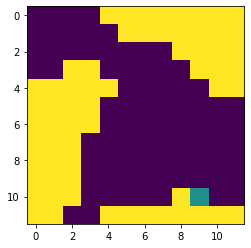

In [11]:
plt.imshow(np.sign(traj['reward_on'][:,:,0]-traj['reward_off'][:,:,0]))

In [22]:
locs = np.zeros((len(traj['loc']),2))
for i,loc in enumerate(traj['loc']):
    locs[i,:] = loc
locs.shape

(1008, 2)

In [24]:
locs_c = np.zeros((643,2))
locs_c[:,0] = locs[:,0][locs[:,0]!=0]
locs_c[:,1] = locs[:,1][locs[:,0]!=0]

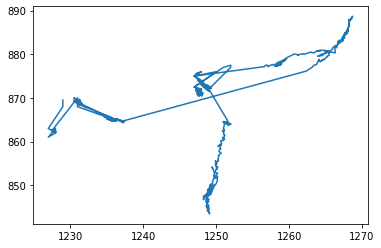

In [25]:
plt.plot(locs_c[:,0],locs_c[:,1])